<a href="https://colab.research.google.com/github/1900690/strawberry/blob/main/eye_camera_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

0.0.1 ファイル作成  
0.0.2 船の動画のＵＲＬ追加  
0.0.3 jsonのリファクタリングサイトのＵＲＬついか  
0.0.4 抽出済みjsonをドライブに追加し,pandasでの整理実験  
0.0.5 pandasでデータ抽出、各データの意味を記載  
0.0.6 元々のjsonからeyedataを抽出  
0.0.7 動画に視線点を描写  
0.0.8 ヒートマップを作成  
0.0.9 クロマキー合成用にグリーンバック動画を作成

テスト用船の動画（15秒）
https://video-ac.com/video/211

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#@title 動画にタイムレコードを描画
from PIL import Image
import cv2

# gifファイル作成用イメージリスト
images =[]

# 動画ファイルのキャプチャー
cap = cv2.VideoCapture('/content/drive/MyDrive/itigo_230316152445.mp4')

# 動画ファイルのフレームレート取得
fps = cap.get(cv2.CAP_PROP_FPS)

# 保存用動画ファイルのフォーマット設定
fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
out = cv2.VideoWriter('/content/timecode.mp4', fourcc, fps, (320, 180))

# 動画を1コマずつ取り込んで処理
while(cap.isOpened()):
    ret, frame = cap.read() # キャプチャー画像の取り込み

    if ret==True: # キャプチャー画像がある場合
        # 現在時間を取得
        time = cap.get(cv2.CAP_PROP_POS_MSEC)

        # 現在のフレーム数を取得
        frame_n = cap.get(cv2.CAP_PROP_POS_FRAMES)

        # タイムコードを作成
        timecode = str(int(time//1000)).zfill(2)+':'+str(int(frame_n%fps)).zfill(2)

        # 縦横半分にリサイズ
        resize = cv2.resize(frame, (320, 180))

        # タイムコードを動画に追加
        #cv2.putText(resize, timecode, (260, 170), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), lineType=cv2.LINE_AA)
        cv2.putText(resize, str(int(frame_n)), (260, 170), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), lineType=cv2.LINE_AA)
        #動画に図形を描写
        #cv2.rectangle(resize, (100, 100), (40, 60), (0, 0, 255))

        # mp4動画を保存
        out.write(resize)

        # opencvからpillow形式に変換しgifファイル作成用リストimagesに追加
        matrix_pil = Image.fromarray(cv2.cvtColor(resize, cv2.COLOR_BGR2RGB))
        images.append(matrix_pil)

    else: # キャプチャー画像がない場合はループ終了
        break

cap.release() # 再生画像をクローズ
out.release() # 出力動画ファイルをクローズ

# gif動画保存
#images[0].save('timecode.gif', save_all=True, append_images=images[1:],
#               optimize=False, duration=1000/fps, loop=0)

In [ ]:
#@title ミリ秒のタイムスタンプを取得
import cv2
#関数定義
def get_timestamps(video_path):
  cap = cv2.VideoCapture(video_path)
  timestamps = [cap.get(cv2.CAP_PROP_POS_MSEC)]
  while cap.isOpened():
    frame_exists, curr_frame = cap.read()
    if not frame_exists:
      break
    timestamp = cap.get(cv2.CAP_PROP_POS_MSEC)
    timestamps.append(timestamp)
  cap.release()
  return timestamps

#動画を指定
movie="/content/timecode.mp4"

#タイムスタンプ取得
timestamps = get_timestamps(movie)
print("タイムスタンプは",timestamps)
print("総フレーム数は",len(timestamps))
#
cap = cv2.VideoCapture(movie)
print("fpsは",cap.get(cv2.CAP_PROP_FPS))
print("動画の長さは",int(len(timestamps)/cap.get(cv2.CAP_PROP_FPS)),"秒")

タイムスタンプは [0.0, 0.0, 33.366700033366705, 66.73340006673341, 100.10010010010011, 133.46680013346682, 166.83350016683352, 200.20020020020021, 233.5669002335669, 266.93360026693364, 300.3003003003003, 333.66700033366703, 367.0337003670337, 400.40040040040043, 433.7671004337671, 467.1338004671338, 500.50050050050055, 533.8672005338673, 567.2339005672338, 600.6006006006006, 633.9673006339673, 667.3340006673341, 700.7007007007007, 734.0674007340674, 767.4341007674341, 800.8008008008009, 834.1675008341675, 867.5342008675342, 900.9009009009009, 934.2676009342676, 967.6343009676343, 1001.0010010010011, 1034.3677010343677, 1067.7344010677346, 1101.1011011011012, 1134.4678011344677, 1167.8345011678346, 1201.2012012012012, 1234.5679012345681, 1267.9346012679346, 1301.3013013013012, 1334.6680013346681, 1368.0347013680348, 1401.4014014014015, 1434.7681014347681, 1468.1348014681348, 1501.5015015015017, 1534.8682015348681, 1568.2349015682348, 1601.6016016016017, 1634.9683016349684, 1668.335001668335, 1

#jsonから視線データを抽出
jsonの構造を把握するには以下のサイトにアクセス
https://jsonformatter.curiousconcept.com/#

In [ ]:
#ファイルコピー
import shutil
shutil.copyfile("/content/drive/MyDrive/itigo_230316152445.json", "/content/itigo_230316152445.json")

'/content/itigo_230316152445.json'

参考;  
https://qiita.com/hrsma2i/items/cd089d00165ae16e56a1  
https://note.nkmk.me/python-pandas-json-normalize/

各データの意味  
このjsonファイルは、EyeDataというキーに対応する値として、目のデータを表すオブジェクトの配列を持っています。各オブジェクトは以下のキーと値を持っています。

**有効なデータの場合**
- eyeValid: 目の有効性を示す数値です。4は両目が有効であることを意味します¹。
- gazePoint0: 左目の視線の座標を示すオブジェクトです。x, y, zはそれぞれ水平方向、垂直方向、奥行き方向の座標を表します。zが-1.0の場合は視線が無効であることを意味します¹。
- gazePoint1: 右目の視線の座標を示すオブジェクトです。x, y, zは同様に座標を表します¹。
- gazeValid: 視線の有効性を示す数値です。20は両目の視線が有効であることを意味します¹。
- gazeVectorLeft: 左目の視線ベクトルを示すオブジェクトです。x, y, zはそれぞれ水平方向、垂直方向、奥行き方向のベクトル成分を表します¹。
- gazeVectorRight: 右目の視線ベクトルを示すオブジェクトです。x, y, zは同様にベクトル成分を表します¹。
- lPupilCenterX: 左目の瞳孔中心の水平方向の座標です²。
- lPupilDiameter: 左目の瞳孔直径です²。
- lPupilDiameterMM: 左目の瞳孔直径（ミリメートル単位）です²。
- leftExData: 左目の拡張データを示すオブジェクトです。blinkはまばたきを示す数値で、0はまばたきしていないことを意味します。eyeDataExBitMaskは拡張データが有効であることを示す数値で、1はeyelidDown, eyelidUp, opennessが有効であることを意味します。eyelidDownは下まぶたの位置、eyelidUpは上まぶたの位置、opennessは目の開き具合を表す数値です³。
- pupilCenter0: 左目の瞳孔中心の座標を示すオブジェクトです。x, yはそれぞれ水平方向、垂直方向の座標を表します。
- pupilCenter1: 右目の瞳孔中心の座標を示すオブジェクトです。x, yは同様に座標を表します。
- pupilRadius0: 左目の瞳孔半径です。
- pupilRadius1: 右目の瞳孔半径です。
- rPupilCenterX: 右目の瞳孔中心の水平方向の座標です²。
- rPupilDiameter: 右目の瞳孔直径です²。
- rPupilDiameterMM: 右目の瞳孔直径（ミリメートル単位）です²。
- recomPoint: 推奨される視点（両目視点）の座標を示すオブジェクトです。x, y, zはそれぞれ水平方向、垂直方向、奥行き方向の座標を表します¹。
- recomValid: 推奨される視点の有効性を示す真偽値です。trueは有効であることを意味します¹。
- rightExData: 右目の拡張データを示すオブジェクトです。blink, eyeDataExBitMask, eyelidDown, eyelidUp, opennessは左目の拡張データと同様に意味します³。
- timestmp: データが取得された時刻を示す数値です¹。

In [3]:
#データを読み込み分解する
import pandas as pd

json_file = "/content/drive/MyDrive/Guest_230725114056.json"
df = pd.read_json(json_file)
df2=df["EyeData"].iloc[2]
df3 = pd.json_normalize(df2)
df4=df["Data"].iloc[3]
df5=pd.json_normalize(df4, record_path='pixelList',meta=['first_frame_tsp','gaze_fps','hint','video_fps'])
df6=df3[['recomValid','recomPoint.x','recomPoint.y']]

#タイムレコードに従った位置に視線を描写

In [ ]:
from PIL import Image
import cv2

# gifファイル作成用イメージリスト
images =[]

# 動画ファイルのキャプチャー
cap = cv2.VideoCapture('/content/drive/MyDrive/itigo_230316152445.mp4')

# 動画ファイルのフレームレート取得
fps = cap.get(cv2.CAP_PROP_FPS)

# 保存用動画ファイルのフォーマット設定
fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
out = cv2.VideoWriter('timecode_and_eye.mp4', fourcc, fps, (320, 180))

# 動画を1コマずつ取り込んで処理
while(cap.isOpened()):
    ret, frame = cap.read() # キャプチャー画像の取り込み

    if ret==True: # キャプチャー画像がある場合
        # 現在時間を取得
        time = cap.get(cv2.CAP_PROP_POS_MSEC)

        # 現在のフレーム数を取得
        frame_n = cap.get(cv2.CAP_PROP_POS_FRAMES)

        # タイムコードを作成
        timecode = str(int(time//1000)).zfill(2)+':'+str(int(frame_n%fps)).zfill(2)

        # 縦横半分にリサイズ
        resize = cv2.resize(frame, (320, 180))

        # タイムコードを動画に追加
        #cv2.putText(resize, timecode, (260, 170), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), lineType=cv2.LINE_AA)
        cv2.putText(resize, str(int(frame_n)), (260, 170), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), lineType=cv2.LINE_AA)
        #視線印を書き込む
        cv2.drawMarker(resize, (int(df6.loc[int(frame_n)][1]*320),int(df6.loc[int(frame_n)][2]*180)), (255, 0, 0))

        # mp4動画を保存
        out.write(resize)

        # opencvからpillow形式に変換しgifファイル作成用リストimagesに追加
        matrix_pil = Image.fromarray(cv2.cvtColor(resize, cv2.COLOR_BGR2RGB))
        images.append(matrix_pil)

    else: # キャプチャー画像がない場合はループ終了
        break

cap.release() # 再生画像をクローズ
out.release() # 出力動画ファイルをクローズ

#視線データを重ね合わせてヒートマップ作成

In [ ]:
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import glob
import shutil
import numpy as np
from google.colab.patches import cv2_imshow


# 動画ファイルのキャプチャー
cap = cv2.VideoCapture('/content/drive/MyDrive/itigo_230316152445.mp4')

#最初のフレームを抽出
cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
ret, frame = cap.read()
first_frame=frame

#動画の縦横サイズとフレーム数を取得
width=int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height=int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
size = (width,height)
gaze_point_size=min(size)//10

#初期値
ellipse=0
x, y = np.mgrid[:height,:width]


# 動画を1コマずつ取り込んで処理
while(cap.isOpened()):
    ret, frame = cap.read() # キャプチャー画像の取り込み

    if ret==True: # キャプチャー画像がある場合

        # 現在のフレーム数を取得
        frame_n = cap.get(cv2.CAP_PROP_POS_FRAMES)

        #視点の範囲を計算
        x_0, y_0 = (int(df6.loc[int(frame_n)][2]*height), int(df6.loc[int(frame_n)][1]*width)) #中央の点
        a, b = (gaze_point_size, gaze_point_size)#円の幅
        ellipse_temp = ((height - x_0)**2/a**2 + (width - y_0)**2/b**2 - 1<0).astype(np.float16)
        ellipse=ellipse+ellipse_temp

    else: # キャプチャー画像がない場合はループ終了
        break

cap.release() # 再生画像をクローズ

#ヒートマップを保存
heat=ellipse*255//int(np.amax(ellipse))
plt.imsave("/content/jet.jpg",heat, cmap="jet")

#最初のフレームと合成
dst=cv2.addWeighted(first_frame, 0.3, cv2.imread("/content/jet.jpg"), 0.7, 0)

cv2_imshow(dst)

NameError: ignored

#グリーンバック視点動画

※視点から取得するデータ※
視点データのFps 60
動画データのFps 30
動画の長さ 00 : 00 : 15
縦横比 [{'height': 736, 'width': 1280}]
縦 736
横 1280


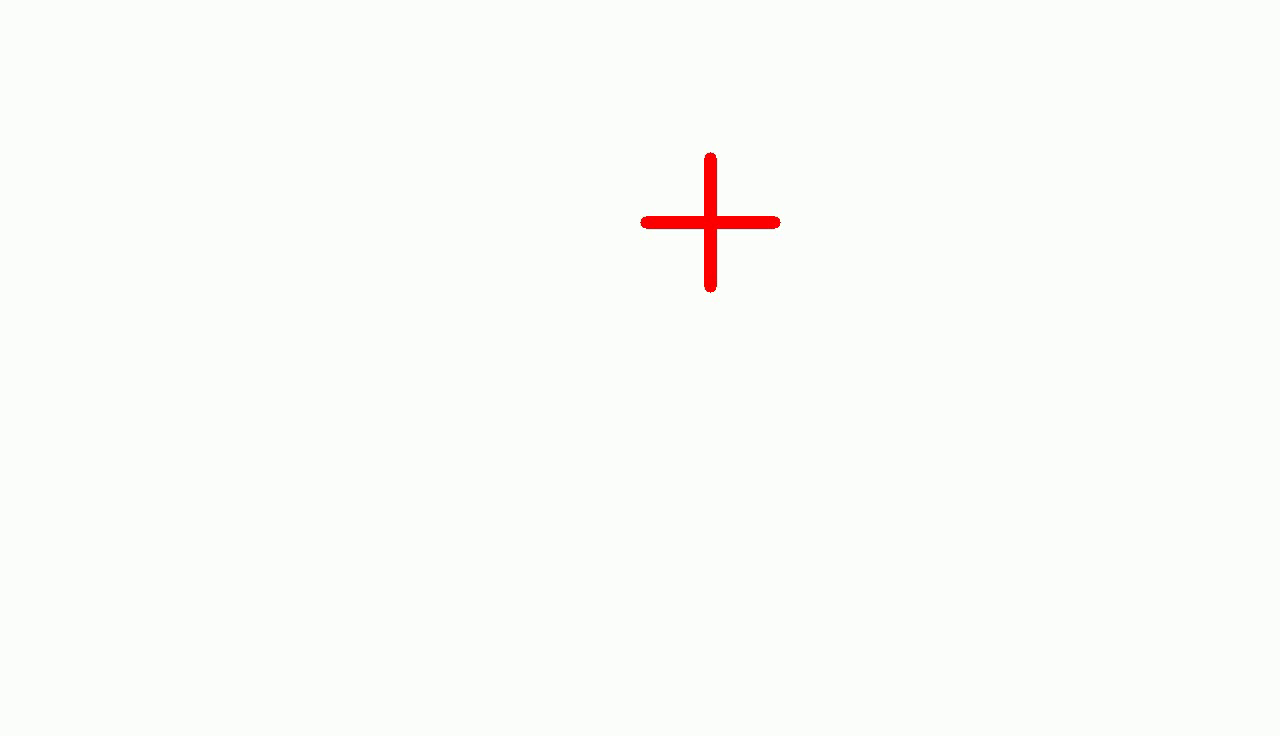

In [67]:
#@title 〇白紙に視線データを描写
#ライブラリをインポート
from pandas.core.base import doc
import shutil
import os
from google.colab import files
import pandas as pd
from PIL import Image
import cv2
from google.colab.patches import cv2_imshow

#データをアップロード
#uploaded = files.upload()
#ファイル名を取得
#ファイル名を記入 = os.path.splitext(list(uploaded.keys())[0])[0]


#視線データを読み込み必要な部分を抽出
json_file ="/content/drive/MyDrive/Guest_230725114056.json"#★"/content/"+ファイル名を記入+".json"
df = pd.read_json(json_file)
df2=df["EyeData"].iloc[2]
df3 = pd.json_normalize(df2)
df6=df3[['recomValid','recomPoint.x','recomPoint.y']]


df7=df["Data"].iloc[3]
df8=df7["pixelList"]
print("※視点から取得するデータ※")
print("視点データのFps",df7["gaze_fps"])
print("動画データのFps",df7["video_fps"])
print("動画の長さ",df7["hint"])
print("縦横比",df7["pixelList"])
print("縦",df8[0]["height"])
print("横",df8[0]["width"])

# 動画ファイルのキャプチャー
cap = cv2.VideoCapture("/content/drive/MyDrive/Guest_230725114056.mp4")#★cap = cv2.VideoCapture("/content/"+ファイル名を記入+".mp4")

# 動画ファイルのフレームレート取得
fps = df7["gaze_fps"]#cap.get(cv2.CAP_PROP_FPS)

#動画のサイズを取得
width = df8[0]["width"]#int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = df8[0]["height"]#int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
size = (width,height)
point_size=max(width,height)

# 保存用動画ファイルのフォーマット設定
fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
out = cv2.VideoWriter("/content/Guest_230725114056_eye_point.mp4", fourcc, fps, size)#★out = cv2.VideoWriter("/content/"+ファイル名を記入+"_eye_point.mp4", fourcc, fps, size)

#白紙作成
white_img = np.ones((1280, 736, 3), np.uint8) * 255
cv2.imwrite('/content/white.jpg', white_img)

# 動画を1コマずつ取り込んで処理
while(cap.isOpened()):
    ret, frame = cap.read() # キャプチャー画像の取り込み

    if ret==True: # キャプチャー画像がある場合
        # 現在時間を取得
        time = cap.get(cv2.CAP_PROP_POS_MSEC)

        # 現在のフレーム数を取得
        frame_n = cap.get(cv2.CAP_PROP_POS_FRAMES)

        # 視点を描画
        frame =cv2.resize(cv2.imread('/content/white.jpg'),size)
        cv2.drawMarker(frame, (int(df6.loc[int(frame_n)][1]*width),int(df6.loc[int(frame_n)][2]*height)), (0, 0, 255),cv2.MARKER_CROSS,int(point_size/10),int(point_size/100))

        # mp4動画を保存
        out.write(frame)

    else: # キャプチャー画像がない場合はループ終了
        break

cap.release() # 再生画像をクローズ
out.release() # 出力動画ファイルをクローズ

#ダウンロード
#★files.download("/content/"+ファイル名を記入+"_eye_point.mp4")

#結果表示用
cap = cv2.VideoCapture("/content/Guest_230725114056_eye_point.mp4")#★cap = cv2.VideoCapture("/content/"+ファイル名を記入+"_eye_point.mp4")
#最初のフレームを抽出
cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
ret, frame = cap.read()
showimg=frame
cv2_imshow(showimg)

※視点から取得するデータ※
視点データのFps 60
動画データのFps 30
動画の長さ 00 : 00 : 15
縦横比 [{'height': 736, 'width': 1280}]
縦 736
横 1280


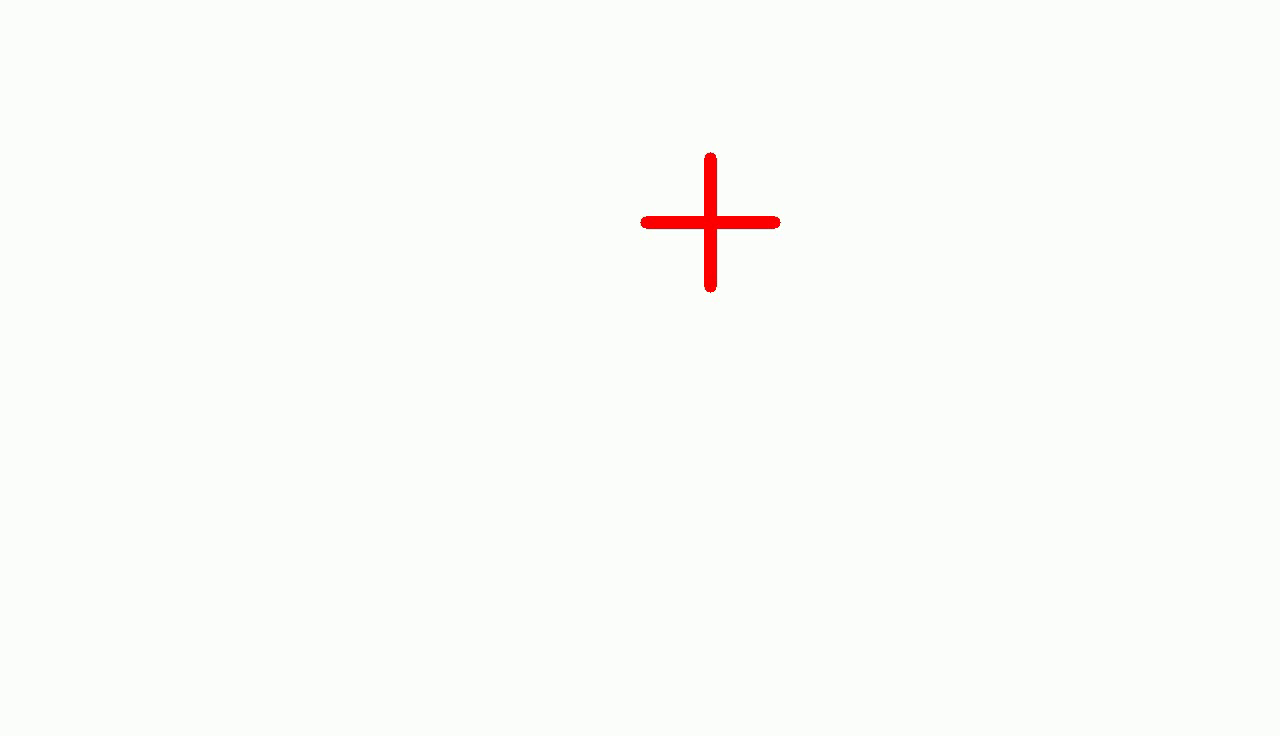

In [66]:
#@title 〇白紙に視線データを描写（重ね合わせ）
#ライブラリをインポート
from pandas.core.base import doc
import shutil
import os
from google.colab import files
import pandas as pd
from PIL import Image
import cv2
from google.colab.patches import cv2_imshow

#データをアップロード
#uploaded = files.upload()
#ファイル名を取得
#ファイル名を記入 = os.path.splitext(list(uploaded.keys())[0])[0]


#視線データを読み込み必要な部分を抽出
json_file ="/content/drive/MyDrive/Guest_230725114056.json"#★"/content/"+ファイル名を記入+".json"
df = pd.read_json(json_file)
df2=df["EyeData"].iloc[2]
df3 = pd.json_normalize(df2)
df6=df3[['recomValid','recomPoint.x','recomPoint.y']]


df7=df["Data"].iloc[3]
df8=df7["pixelList"]
print("※視点から取得するデータ※")
print("視点データのFps",df7["gaze_fps"])
print("動画データのFps",df7["video_fps"])
print("動画の長さ",df7["hint"])
print("縦横比",df7["pixelList"])
print("縦",df8[0]["height"])
print("横",df8[0]["width"])

# 動画ファイルのキャプチャー
cap = cv2.VideoCapture("/content/drive/MyDrive/Guest_230725114056.mp4")#★cap = cv2.VideoCapture("/content/"+ファイル名を記入+".mp4")

# 動画ファイルのフレームレート取得
fps = df7["gaze_fps"]#cap.get(cv2.CAP_PROP_FPS)

#動画のサイズを取得
width = df8[0]["width"]#int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = df8[0]["height"]#int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
size = (width,height)
point_size=max(width,height)

# 保存用動画ファイルのフォーマット設定
fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
out = cv2.VideoWriter("/content/Guest_230725114056_eye_point.mp4", fourcc, fps, size)#★out = cv2.VideoWriter("/content/"+ファイル名を記入+"_eye_point.mp4", fourcc, fps, size)

#白紙作成
white_img = np.ones((1280, 736, 3), np.uint8) * 255
cv2.imwrite('/content/white.jpg', white_img)
white=cv2.resize(cv2.imread('/content/white.jpg'),size)

# 動画を1コマずつ取り込んで処理
while(cap.isOpened()):
    ret, frame = cap.read() # キャプチャー画像の取り込み

    if ret==True: # キャプチャー画像がある場合
        # 現在時間を取得
        time = cap.get(cv2.CAP_PROP_POS_MSEC)

        # 現在のフレーム数を取得
        frame_n = cap.get(cv2.CAP_PROP_POS_FRAMES)

        # 視点を描画
        frame = white
        cv2.drawMarker(frame, (int(df6.loc[int(frame_n)][1]*width),int(df6.loc[int(frame_n)][2]*height)), (0, 0, 255),cv2.MARKER_CROSS,int(point_size/10),int(point_size/100))

        # mp4動画を保存
        out.write(frame)

    else: # キャプチャー画像がない場合はループ終了
        break

cap.release() # 再生画像をクローズ
out.release() # 出力動画ファイルをクローズ

#ダウンロード
#★files.download("/content/"+ファイル名を記入+"_eye_point.mp4")

#結果表示用
cap = cv2.VideoCapture("/content/Guest_230725114056_eye_point.mp4")#★cap = cv2.VideoCapture("/content/"+ファイル名を記入+"_eye_point.mp4")
#最初のフレームを抽出
cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
ret, frame = cap.read()
showimg=frame
cv2_imshow(showimg)

In [63]:
import cv2

black_img = np.ones((1280, 736, 3), np.uint8) * 255
cv2.imwrite('/content/black.jpg', black_img)

fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
video = cv2.VideoWriter('/content/video.mp4', fourcc, 30, (1280, 736))

for i in range(0, 90 + 1):
    img = cv2.resize(cv2.imread('/content/black.jpg'), (1280, 736))
    video.write(img)

video.release()